In [1]:
import numpy as np
from matplotlib.lines import Line2D
from expm_mul import expm_multiply
from scipy.sparse.linalg import eigs,norm
from scipy.special import factorial
import matplotlib.pyplot as plt
from fractions import Fraction
from scipy.sparse import csr_matrix,isspmatrix,bmat
import scipy as sci
from qutip import qload
def get_creation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=-1)
def get_annihilation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=1)
def _expm_multiply_simple_core_global(A, B, tol=None):
    """
    A helper function.
    """
    if tol is None:
        tol =1e-16
    s=100
    F = B

    c1 = _exact_1_norm(B)
    j=0
    while(1):
        coeff = s*(j+1)
        B =  A.dot(B)/coeff
        c2 = _exact_1_norm(B)
        F = F + B
        total_norm=norm_state(F)
        if (c1+c2)<tol*total_norm:
            m=j+1
            break
        c1 = c2
        j=j+1
    F =  F
    B = F
    for i in range(1,int(s)):
        c1=c2
        for j in range(m):
            coeff = s*(j+1)
            B =  A.dot(B)/coeff
            F = F + B
        F =  F
        B = F
    return F, s
def get_s(A,b,tol):
    s=1
    if A.dtype==np.complex256:
        s=np.ceil(_exact_1_norm(A))
    else:
        while(1):
            norm_A = _exact_inf_norm(A)/s
            max_term_notation=np.floor(norm_A)
            max_term=1
            for i in range(1,np.int(max_term_notation)):
                max_term=max_term*norm_A/i
                if max_term >= 10**16:
                    break
            if 10**-16 * max_term <= tol:
                break
            s=s+1
    return s
def _exact_1_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=0).flat)
    else:
        return np.linalg.norm(A, 1)
def _expm_multiply(A, B, tol=None):
    """
    A helper function.
    """
    if tol is None:
        tol =1e-16
    s=1
    F = B

    c1 = _exact_1_norm(B)
    j=0
    max_mag = c1
    while(1):
        coeff = s*(j+1)
        B =  A.dot(B)/coeff
        c2 = _exact_1_norm(B)
        if c2 > max_mag:
            max_mag = c2
        F = F + B
        total_norm=norm_state(F)
        if (c1+c2)<tol*total_norm:
            m=j+1
            break
        c1 = c2
        j=j+1
    F =  F
    B = F
    for i in range(1,int(s)):
        c1=c2
        for j in range(m):
            coeff = s*(j+1)
            B =  A.dot(B)/coeff
            F = F + B
        F =  F
        B = F
    return F, max_mag
def overnorm(A):
    if A.dtype==np.complex256:
        return _exact_inf_norm(A)
    else:
        return norm_two(A)
def _exact_inf_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=1).flat)
    else:
        return np.linalg.norm(A, np.inf)
def norm_two(A):
    if sci.sparse.isspmatrix(A):
        A=csr_matrix(A).conjugate().transpose()
        return np.sqrt(abs(eigs(A=A.dot(A),k=1,which='LM',return_eigenvectors=False)[0]))
    else:
        return np.linalg.norm(A)
def norm_state(A):
    return np.linalg.norm(A)
def block_fre(A,E):
    if isspmatrix(A) is False:
        A = np.block([[A, E], [np.zeros_like(A), A]])
    else:
        A = bmat([[A, E], [None, A]]).tocsc()
    return A
def difference(A,B):
    return overnorm(A-B)/overnorm(A)
def get_H(dim,tp):
    HILBERT_SIZE=dim
    Q_dim=6
    g=0.1*2*np.pi
    anharmonicity =-0.225
    a_dag = get_creation_operator(HILBERT_SIZE,tp)
    a = get_annihilation_operator(HILBERT_SIZE,tp)
    b_dag=get_creation_operator(Q_dim,tp)
    b=get_annihilation_operator(Q_dim,tp)
    A=np.kron(a,np.identity(Q_dim))
    A_dag=np.kron(a_dag,np.identity(Q_dim))
    B=np.kron(np.identity(HILBERT_SIZE),b)
    B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
    H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
    H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
    H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
    vec=1/np.sqrt(HILBERT_SIZE*Q_dim)*np.ones(HILBERT_SIZE*Q_dim)
    return H,vec
def get_auxiliary(dim,tp,t):
    HILBERT_SIZE=dim
    Q_dim=6
    g=0.1*2*np.pi
    anharmonicity =-0.225
    a_dag = get_creation_operator(HILBERT_SIZE,tp)
    a = get_annihilation_operator(HILBERT_SIZE,tp)
    b_dag=get_creation_operator(Q_dim,tp)
    b=get_annihilation_operator(Q_dim,tp)
    A=np.kron(a,np.identity(Q_dim))
    A_dag=np.kron(a_dag,np.identity(Q_dim))
    B=np.kron(np.identity(HILBERT_SIZE),b)
    B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
    H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
    H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
    H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
    vec=1/np.sqrt(HILBERT_SIZE*Q_dim)*np.ones(2*HILBERT_SIZE*Q_dim)
    vec[0:HILBERT_SIZE*Q_dim]=0
    A=block_fre(t*H,-1j*(B+B_dag))
    return A,vec
def get_norm(ts):
    tp=np.float64()
    anorm=[]
    for i in range(len(ts)):
        HILBERT_SIZE=20
        Q_dim=6
        g=0.1*2*np.pi
        anharmonicity =-0.225
        a_dag = get_creation_operator(HILBERT_SIZE,tp)
        a = get_annihilation_operator(HILBERT_SIZE,tp)
        b_dag=get_creation_operator(Q_dim,tp)
        b=get_annihilation_operator(Q_dim,tp)
        A=np.kron(a,np.identity(Q_dim))
        A_dag=np.kron(a_dag,np.identity(Q_dim))
        B=np.kron(np.identity(HILBERT_SIZE),b)
        B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
        H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
        H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
        H=ts[i]*csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
        anorm.append(norm_two(H))
    return anorm
def get_norm_der(ts):
    tp=np.float64()
    anorm=[]
    for i in range(len(ts)):
        HILBERT_SIZE=20
        Q_dim=6
        g=0.1*2*np.pi
        anharmonicity =-0.225
        a_dag = get_creation_operator(HILBERT_SIZE,tp)
        a = get_annihilation_operator(HILBERT_SIZE,tp)
        b_dag=get_creation_operator(Q_dim,tp)
        b=get_annihilation_operator(Q_dim,tp)
        A=np.kron(a,np.identity(Q_dim))
        A_dag=np.kron(a_dag,np.identity(Q_dim))
        B=np.kron(np.identity(HILBERT_SIZE),b)
        B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
        H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
        H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
        H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
        A=ts[i]*block_fre(H,-1j*(A+A_dag))
        anorm.append(norm_two(A))
    return anorm

In [149]:
reference = qload('refer')[0]
theta_m=np.array([[8.70950435e-01, 2.48853043e+00, 4.02062662e+00, 5.51075280e+00,
        6.97775212e+00, 8.43027209e+00, 9.87290220e+00, 1.13089234e+01,
        1.27393366e+01, 1.41653119e+01, 1.55887688e+01],
       [1.79283319e-01, 1.30547755e+00, 2.68990434e+00, 4.11674468e+00,
        5.55078449e+00, 6.98409736e+00, 8.41474411e+00, 9.84240944e+00,
        1.12672525e+01, 1.26895571e+01, 1.41096178e+01],
       [0.13,1, 2.2, 3.6,
        4.9, 6.3, 7.7, 9.1,
        11, 12, 1.3],
       [5.87845778e-03, 3.11153531e-01, 1.11496247e+00, 2.19235380e+00,
        3.40348589e+00, 4.68492721e+00, 6.00642014e+00, 7.35228229e+00,
        8.71376145e+00, 1.00856663e+01, 1.14647607e+01],
        [0.003307471010225917,0.24259255239783006,0.9560279579613657,1.9645322216064995,3.1267463661459876,4.372820117778894,5.667919829026178,6.993478543263042,8.338922480962493,9.697877908033124,11.066316441049558 ],
       [2.3e-03, 0.14, 0.64, 1.4,
        2.4, 3.5, 4.7, 6,
        7.2, 8.5, 9.9]])
theta_mm=[]
for j,_theta in enumerate(theta_m):
    a={5:0,10:0,15:0,20:0,25:0,30:0,35:0,40:0,45:0,50:0,55:0}
    for i, theta in enumerate(_theta):
        a[5*(i+1)] = theta
    theta_mm.append(a)

Loaded list object.


In [150]:
dim=6
ts = np.linspace(0.1,2,100)
new_error1=np.zeros((len(ts)))
max_mag=np.zeros((len(ts)))
ref = reference['state_propagator']
for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    sas_st,x = expm_multiply(t*H, vec, theta_mm[j],1e-16)
    sas,max_mag[i]=_expm_multiply_simple_core_global(t*H, vec,1e-16)
    new_error1[i]=(norm_two(sas-sas_st)/norm_two(sas_st))

In [151]:
import scipy.sparse as sp
from scipy import stats
def dagger(A):
    A = sp.csr_matrix.transpose(A)
    return sp.csr_matrix.conjugate(A)
def randomH(loc,scale,sparsity):
    rvs = stats.norm(loc,scale=scale).rvs
    dim=1000
    A = sp.random(dim,dim,sparsity/4, data_rvs=rvs)+ 1j*sp.random(dim,dim,sparsity/4, data_rvs=rvs)
    H =2.5*( A + dagger(A))
    return -1j*H

In [152]:
sparsity = np.linspace(1e-5,1e-2,100)
loc=0
scale=2
matrix = []
for i in range(len(sparsity)):
    matrix.append(randomH(loc,scale,sparsity[i]))
matrices = np.array(matrix)
vec = np.sqrt(1/1000)*np.ones(1000)
max_mag=np.zeros(len(matrices))
new_error1=np.zeros(len(matrices))
norm=np.zeros(len(matrices))
for i,matrix in enumerate(matrices):
    sas,max_mag[i]=_expm_multiply(matrix, vec,1e-16)
    sas_st,x = _expm_multiply_simple_core_global(matrix, vec,1e-16)
    new_error1[i]=norm_two(sas-sas_st)
    norm[i]=(_exact_inf_norm(matrix))


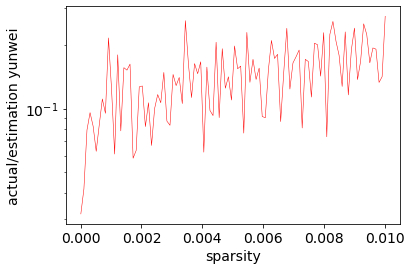

In [144]:
bound=np.zeros(100)
for i,each_norm in enumerate(norm):
    bound[i]=1e-16
    for j in range(1,int(np.floor(each_norm))+1):
        bound[i]=bound[i]*each_norm/j
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots()
ax.plot(sparsity,new_error1/bound,color='red', linewidth=0.5)
ax.set_ylabel('actual/estimation yunwei')
ax.set_xlabel('sparsity')
ax.set_yscale('log')
plt.savefig('sparsity.pdf',bbox_inches='tight')

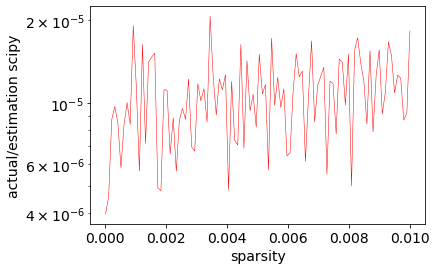

In [145]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots()
gamma=1e-13
ax.plot(sparsity,new_error1/(gamma*np.exp(norm)),color='red', linewidth=0.5)
ax.set_ylabel('actual/estimation scipy')
ax.set_xlabel('sparsity')
ax.set_yscale('log')
plt.savefig('sparsity.pdf',bbox_inches='tight')

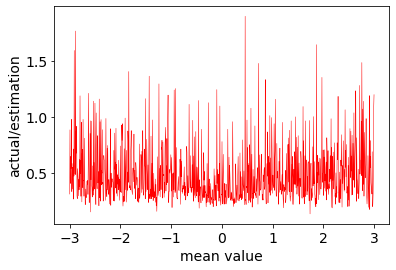

In [123]:
loc = np.linspace(-3,3,1000)
scale = 1
sparsity = 1e-4
matrix = []
for i in range(len(loc)):
    matrix.append(randomH(loc[i],scale,sparsity))
matrices = np.array(matrix)
vec = np.sqrt(1/1000)*np.ones(1000)
max_mag=np.zeros(len(matrices))
new_error1=np.zeros(len(matrices))
norm=np.zeros(len(matrices))
for i,matrix in enumerate(matrices):
    sas,max_mag[i]=_expm_multiply(matrix, vec,1e-16)
    sas_st,x = _expm_multiply_simple_core_global(matrix, vec,1e-16)
    new_error1[i]=norm_two(sas-sas_st)
    norm[i]=(_exact_inf_norm(matrix))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots()
ax.plot(loc,new_error1/(1e-16*max_mag),color='red', linewidth=0.5)
ax.set_ylabel('actual/estimation')
ax.set_xlabel('mean value')
plt.savefig('loc.pdf',bbox_inches='tight')

In [124]:
np.sum(new_error1/(1e-16*max_mag))/1000

0.48057424253893893

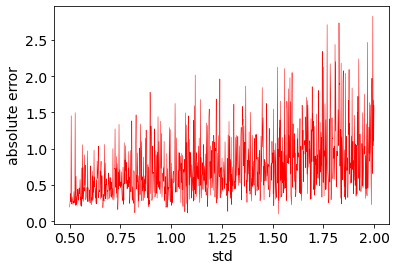

In [54]:
loc = 0
scale = np.linspace(0.5,2,1000)
sparsity = 1e-4
matrix = []
for i in range(len(scale)):
    matrix.append(randomH(loc,scale[i],sparsity))
matrices = np.array(matrix)
vec = np.sqrt(1/1000)*np.ones(1000)
max_mag=np.zeros(len(matrices))
new_error1=np.zeros(len(matrices))
norm=np.zeros(len(matrices))
for i,matrix in enumerate(matrices):
    sas,max_mag[i]=_expm_multiply(matrix, vec,1e-16)
    sas_st,x = _expm_multiply_simple_core_global(matrix, vec,1e-16)
    new_error1[i]=norm_two(sas-sas_st)
    norm[i]=(_exact_inf_norm(matrix))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots()
ax.plot(scale,new_error1/(1e-16*max_mag),color='red', linewidth=0.5)
ax.set_ylabel('actual/estimation')
ax.set_ylabel('absolute error')
ax.set_xlabel('std')
plt.savefig('scale.pdf',bbox_inches='tight')

In [58]:
loc = 0
scale = 1
sparsity = 1e-4
matrix = []
x=np.linspace(-2.5,2.5,1000)
for i in range(len(x)):
    matrix.append(x[i]*randomH(loc,scale,sparsity))
matrices = np.array(matrix)
vec = np.sqrt(1/1000)*np.ones(1000)
max_mag=np.zeros(len(matrices))
new_error1=np.zeros(len(matrices))
norm=np.zeros(len(matrices))
for i,matrix in enumerate(matrices):
    sas,max_mag[i]=_expm_multiply(matrix, vec,1e-16)
    sas_st,m = _expm_multiply_simple_core_global(matrix, vec,1e-16)
    new_error1[i]=norm_two(sas-sas_st)
    norm[i]=(_exact_inf_norm(matrix))

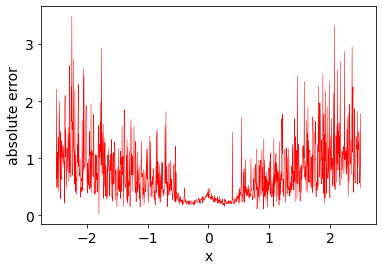

In [59]:

plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots()
ax.plot(x,new_error1/(1e-16*max_mag),color='red', linewidth=0.5)
ax.set_ylabel('actual/estimation')
ax.set_ylabel('absolute error')
ax.set_xlabel('x')
plt.savefig('x.pdf',bbox_inches='tight')

In [11]:
norm_two(sas_st)

0.9999112717398958

In [719]:
def TE(a):
    b=1
    j=1
    total=1
    maximum=0
    while 1:
        b=b*a/j
        total=total+b
        j=j+1
        if abs(b)>maximum:
            maximum = abs(b)
        if abs(b)<1e-16:
            break
    return total,j
def array_TE(A):
    totals=np.zeros(len(A),dtype=np.complex256)
    maximum=np.zeros(len(A))
    for i,a in enumerate(A):
        totals[i],maximum[i]=TE(a)
    return totals,maximum

In [721]:
A=1j*np.linspace(1,30,1000)
diff=abs(array_TE(A)[0]-np.exp(A))
maximum=1e-16*array_TE(A)[1]

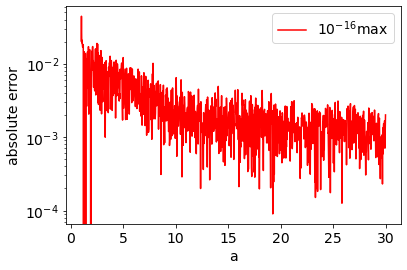

In [725]:
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 14})
ax.plot(abs(A),abs(diff)/(maximum*np.exp(abs(A))),label='$10^{-16}$max',color='red')
ax.set_ylabel('absolute error')
ax.set_xlabel('a')
ax.set_yscale('log')
ax.legend()
plt.savefig('exp_a.pdf',bbox_inches='tight')

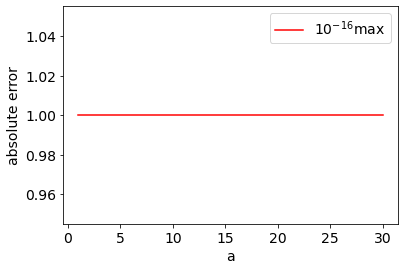

In [12]:
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 14})
ax.plot(abs(A),abs(np.exp(A)),label='$10^{-16}$max',color='red')
# ax.set_yscale('log')
ax.set_ylabel('absolute error')
ax.set_xlabel('a')
ax.legend()
plt.savefig('exp_a.pdf',bbox_inches='tight')

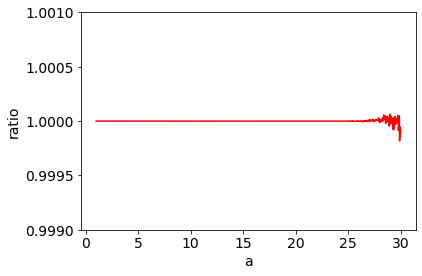

In [17]:
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 14})
ax.plot(abs(A),np.abs(array_TE(A)[0]),color='red')
ax.set_ylabel('ratio')
ax.set_xlabel('a')
ax.set_ylim([0.999,1.001])
plt.savefig('exp_a.pdf',bbox_inches='tight')

In [9]:
abs(array_TE(A)[0])

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [69]:
maximum

array([1.00000000e-16, 1.02902903e-16, 1.05805806e-16, 1.08708709e-16,
       1.11611612e-16, 1.14514515e-16, 1.17417417e-16, 1.20320320e-16,
       1.23223223e-16, 1.26126126e-16, 1.29029029e-16, 1.31931932e-16,
       1.34834835e-16, 1.37737738e-16, 1.40640641e-16, 1.43543544e-16,
       1.46446446e-16, 1.49349349e-16, 1.52252252e-16, 1.55155155e-16,
       1.58058058e-16, 1.60960961e-16, 1.63863864e-16, 1.66766767e-16,
       1.69669670e-16, 1.72572573e-16, 1.75475475e-16, 1.78378378e-16,
       1.81281281e-16, 1.84184184e-16, 1.87087087e-16, 1.89989990e-16,
       1.92892893e-16, 1.95795796e-16, 1.98698699e-16, 2.03216029e-16,
       2.09110462e-16, 2.15089163e-16, 2.21152133e-16, 2.27299371e-16,
       2.33530878e-16, 2.39846653e-16, 2.46246697e-16, 2.52731009e-16,
       2.59299590e-16, 2.65952439e-16, 2.72689556e-16, 2.79510942e-16,
       2.86416597e-16, 2.93406520e-16, 3.00480711e-16, 3.07639171e-16,
       3.14881899e-16, 3.22208896e-16, 3.29620161e-16, 3.37115694e-16,
      

In [35]:
1e-16*TE(11.2j)[1]

8.714501145746933e-13

In [9]:
import jax.numpy as jnp
import jax

In [10]:
def customize_c(psi_N,psi_T):
    return 1-jnp.linalg.norm(psi_N-psi_T)

In [73]:
x = 1
l2_dist_sq = lambda z: jnp.abs(z+1)**2
jax.grad(l2_dist_sq,holomorphic=True)(0-1j*x)

TypeError: grad with holomorphic=True requires outputs with complex dtype, but got float32.

In [70]:
def f(z):
    x, y = jnp.real(z), jnp.imag(z)
    return x + x*y**2

z = 3. +1j
jax.grad(f,holomorphic=True)(z)

TypeError: grad with holomorphic=True requires outputs with complex dtype, but got float32.

In [72]:
A = jnp.array([[5.,    2.+3j,    5j],
              [2.-3j,   7.,  1.+7j],
              [-5j,  1.-7j,    12.]])

def f(X):
    L = jnp.linalg.cholesky(X)
    return jnp.sum((L - jnp.sin(L))**2)

jax.grad(f, holomorphic=True)(A)

DeviceArray([[-0.7534186  +0.j      , -3.0509028 -10.940545j,
               5.9896846  +3.542303j],
             [-3.0509028 +10.940545j, -8.904491   +0.j      ,
              -5.1351523  -6.559373j],
             [ 5.9896846  -3.542303j, -5.1351523  +6.559373j,
               0.01320427 +0.j      ]], dtype=complex64)

In [ ]:
u = 1.11e-16
def gamma_fa(n):
    return n*u/(1-n*u)
def beta(norm,m,n):
    beta=gamma_fa(m+1)
    r = 1
    for i in range(1,m):
        r=r*norm/i
        g = gamma_fa(i*(n+2)+m+2)
        beta = beta+g*r
    return beta
def error(norm_A,m,s):]
    n=1000
    rd=beta(norm_A/s,m,n)
    a=1
    tr=0
    for i in range(1,1000):
        a=a*norm_A/s/i
        if i>=m+1:
            tr=tr+a
    rd=np.power((1+rd+tr),s)-np.power((1+tr),s)
    tr=tr*s
    tr=tr*((1-np.power(tr,s))/(1-tr))
    return tr+rd

In [485]:

def gamma_fa(n):
    u = 1.11e-16
    return n*u/(1-n*u)
def beta(norm,m,n):
    beta=gamma_fa(m+1)
    r = 1
    for i in range(1,m):
        r=r*norm/i
        g = gamma_fa(i*(n+2)+m+2)
        beta = beta+g*r
    return beta
def error(norm_A,m,s,n):
    rd=beta(norm_A/s,m,n)
    a=1
    tr=0
    for i in range(1,1000):
        a=a*norm_A/s/i
        if i>=m+1:
            tr=tr+a
    rd=np.power((1+rd+tr),s)-np.power((1+tr),s)
    tr=tr*s
    tr=tr*((1-np.power(tr,s))/(1-tr))
    return tr+rd
def choose_ms(norm_A,d,tol):
    no_solution=True
    for i in range(np.floor(norm_A)):
        for j in range(100):
            if error(norm_A,i,j)<tol:
                no_solution = False
                s=i
                m=j
                break
    if no_solution==False:
        return s,m
    if no_solution == True:
        raise ValueError("please lower the error tolerance ")
def _exact_inf_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=1).flat)
    else:
        return np.linalg.norm(A, np.inf)
def max_row_number(sparse_matrix):
    row_indice=sparse_matrix.nonzero()[0]
    indice_count=1
    max_count=1
    for i in range(len(row_indice)): 
        if i==0:
            indice=row_indice[0]
        else:
            if indice==row_indice[i]:
                indice_count=indice_count+1
            else:
                if indice_count>max_count:
                    max_count=indice_count
                indice=row_indice[i]
                indice_count=1
    return max_count
def expm_fullm(A, B, tol=None):
    """
    A helper function.
    """
    if tol is None:
        tol =1e-5
    if sci.sparse.isspmatrix(A):
        d=len(A)
    else:
        d=max_row_number(A)
    norm_A = _exact_inf_norm(A)
    s,m=choose_ms(norm_A,d,tol)
    for i in range(int(s)):
        for j in range(m):
            coeff = s*(j+1)
            B =  A.dot(B)/coeff
            F = F + B
        B = F
    return F

In [ ]:
def _expm_multiply_simple_core_global(A, B, tol=None):
    """
    A helper function.
    """
    if tol is None:
        tol =1e-5
    if sci.sparse.isspmatrix(A):
        d=len(A)
    else:
        d=max_row_number(A)
    norm_A = _exact_inf_norm(A)
    s,m=choose_ms(norm_A,d,tol)
    F = B

    c1 = _exact_1_norm(B)
    j=0
    while(1):
        coeff = s*(j+1)
        B =  A.dot(B)/coeff
        c2 = _exact_1_norm(B)
        F = F + B
        total_norm=norm_state(F)
        if (c1+c2)<tol*total_norm:
            m=j+1
            break
        c1 = c2
        j=j+1
    F =  F
    B = F
    for i in range(1,int(s)):
        c1=c2
        for j in range(m):
            coeff = s*(j+1)
            B =  A.dot(B)/coeff
            F = F + B
        F =  F
        B = F
    return F

In [472]:
np.floor(100.5)

100.0

In [602]:
def error(norm_A,m,s):
    tol=1e-12
    n=1000
    rd=beta(norm_A/s,m,n)
    a=1
    tr=0
    for i in range(1,1000):
        a=a*norm_A/s/i
        if i>=m+1:
            tr=tr+a
    rd=np.power((1+rd+tr),s)-np.power((1+tr),s)
    tr=tr*s
    tr=tr*((1-np.power(tr,s))/(1-tr))
    return tr+rd-tol

In [603]:
error(56.44,33,8)

9.700651521915968e-09

In [604]:
sci_table=np.array([0.13,1, 2.2, 3.6,
        4.9, 6.3, 7.7, 9.1,
        11, 12, 13])
def determine_ms(norm_A):
    s=1
    m=0
    norm_B=norm_A
    while(1):
        for i in range(len(sci_table)):
            if norm_B<=sci_table[i]:
                m=5*(i+1)
                break  
        if m==0:
            s=s+1
            norm_B=norm_A/s
        else:
            break
    scipy_ms=m*s
    s=1
    m=0
    norm_B=norm_A
    for s in range(1,1000):
        for m in range(1,100):
            totalerror=error(norm_A,m,s)
            if totalerror<=0:
                break
        if totalerror<=0:
                break  
    print("scipy: "+str(scipy_ms)+ " me "+str(m*s))
    return s,m

In [605]:
determine_ms(80)

<ipython-input-602-b12f20b9cb8e>:13: RuntimeWarning: overflow encountered in power
  tr=tr*((1-np.power(tr,s))/(1-tr))


scipy: 350 me 98901


(999, 99)

In [503]:
scipy_ms=[]
me_ms=[]
for i in range(1,130): 
    result=determine_ms(i)
    scipy_ms.append(result[0])
    me_ms.append(result[1])

KeyboardInterrupt: 

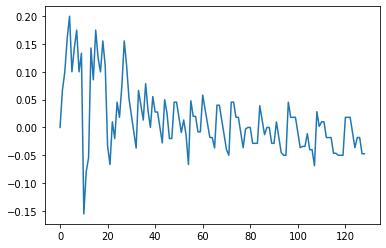

In [445]:
plt.plot((np.array(scipy_ms)-np.array(me_ms))/np.array(scipy_ms))

In [ ]:
for i in range(300,310):
    print(i)
    determine_ms(i)

In [668]:

def t_error(norm_A,m,s):
    tol=1e-5
    n=5
    rd=beta(norm_A/s,m,n)
    a=1
    tr=0
    for i in range(1,1000):
        a=a*norm_A/s/i
        if i>=m+1:
            tr=tr+a
    rd=np.power((1+rd+tr),s)-np.power((1+tr),s)
    tr=tr*s
    tr=tr*((1-np.power(tr,s))/(1-tr))
    return tr+rd
def ms(norm_A):
    maximum_s=80
    ms=np.zeros(maximum_s-1)
    mm=np.zeros(maximum_s-1)
    ss=np.zeros(maximum_s-1)
    for s in range(1,maximum_s):
        m=1
        while(1):
            if m==1:
                total_error_prime=t_error(norm_A,1,s)
            total_error = t_error(norm_A,m,s)
            if total_error<=1e-5:
                no_solution=False
                break
            if (total_error > total_error_prime):
                no_solution=True
                break
            total_error_prime=total_error
            m=m+1
        if (no_solution==True):
            ms[s-1]="nan"
        else:
            ms[s-1]=s*m
            mm[s-1]=m
            ss[s-1]=s
    return ms,mm,ss

In [669]:
t_error(414.750316,24,165)

9.975229727664404e-12

In [665]:
ms(41.4750316)[1]

array([ 0.,  0., 46., 37., 31., 27., 25., 23., 21., 20., 18., 18., 17.,
       16., 15., 15., 14., 14., 14., 13., 13., 13., 12., 12., 12., 12.,
       12., 11., 11., 11., 11., 11., 11., 10., 10., 10., 10., 10., 10.,
       10., 10., 10.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
        9.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.])

In [666]:
ms(410)[1]

<ipython-input-663-c94aea2f5dc5>:13: RuntimeWarning: overflow encountered in power
  tr=tr*((1-np.power(tr,s))/(1-tr))


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 56., 54.,
       52., 50., 49., 48., 46., 45., 44., 43., 42., 41., 41., 40., 39.,
       38., 38., 37., 36., 36., 35., 35., 34., 34., 33., 33., 32., 32.,
       31., 31., 30., 30., 30., 29., 29., 29., 28., 28., 28., 28., 27.,
       27., 27., 26., 26., 26., 26., 25., 25., 25., 25., 25., 24., 24.,
       24.])

In [497]:
ms(56.44)[0]

array([ nan,  nan,  nan,  nan, 225., 234., 252., 264., 270., 280., 297.,
       312., 312., 322., 345., 352., 357., 378., 380., 380., 399., 418.,
       414., 432., 450., 442., 459., 476., 464., 480., 496., 512., 495.,
       510., 525., 540., 555., 570., 546.])

In [350]:
result=[]
norms=np.linspace(1,100,100)
ms_table=[]
for norm in norms:
    a=ms(norm)
    ms_table.append(a)
    index=[]
    for i in range(len(a)):
        if a[i]>=0:
            first=a[i]
            a=np.delete(a,index)
            break
        else:
            index.append(i)
    result.append(first==np.min(a))

KeyboardInterrupt: 

In [325]:
for i in range(100):
    if result[i]==False:
        print(i)

53
60
61
69
76
84
92
96
98
99


In [2]:
import numpy as np
command="temci short exec "
a=np.array([2,5,8,12])
for j in range(4):
    for i in range(1,11):
        command = command+" \"python sci_"+str(a[j])+"_t"+str(i)+".py\""
command=command + " --runs 1"

In [3]:
command

'temci short exec  "python sci_2_t1.py" "python sci_2_t2.py" "python sci_2_t3.py" "python sci_2_t4.py" "python sci_2_t5.py" "python sci_2_t6.py" "python sci_2_t7.py" "python sci_2_t8.py" "python sci_2_t9.py" "python sci_2_t10.py" "python sci_5_t1.py" "python sci_5_t2.py" "python sci_5_t3.py" "python sci_5_t4.py" "python sci_5_t5.py" "python sci_5_t6.py" "python sci_5_t7.py" "python sci_5_t8.py" "python sci_5_t9.py" "python sci_5_t10.py" "python sci_8_t1.py" "python sci_8_t2.py" "python sci_8_t3.py" "python sci_8_t4.py" "python sci_8_t5.py" "python sci_8_t6.py" "python sci_8_t7.py" "python sci_8_t8.py" "python sci_8_t9.py" "python sci_8_t10.py" "python sci_12_t1.py" "python sci_12_t2.py" "python sci_12_t3.py" "python sci_12_t4.py" "python sci_12_t5.py" "python sci_12_t6.py" "python sci_12_t7.py" "python sci_12_t8.py" "python sci_12_t9.py" "python sci_12_t10.py" --runs 1'